# Test Auto ML H2O

## Installation des packages nécessaires

In [3]:
#!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=f7c991180f32f64f6719472bf07e8b1688d451820a1c57cc7062bf2f5665799f
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.9 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=136b43257d5a7ec49d5c7cd401d87540f8816c478096b8cfc6102de95098fae0
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


## Téléchargement du fichier

## Récupération des packages nécessaires

In [5]:
import h2o
h2o.init()
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
import lazypredict
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from   tpot  import TPOTRegressor, TPOTClassifier
from   sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
df_vegetable = pd.read_csv('Vegetable_market.csv')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,56 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_unknownUser_ooczfk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Analyse des données

### Extrait du jeu de données

In [6]:
df_vegetable


,Vegetable,Season,Month,Temp,Deasaster Happen in last 3month,Vegetable condition,Price per kg
0,potato,winter,jan,15,no,fresh,20
1,tomato,winter,jan,15,no,fresh,50
2,peas,winter,jan,15,no,fresh,70
3,pumkin,winter,jan,15,no,fresh,25
4,cucumber,winter,jan,15,no,fresh,20
...,...,...,...,...,...,...,...
116,brinjal,winter,jan,15,yes,fresh,33
117,ginger,winter,jan,15,no,fresh,88
118,potato,summer,apr,32,no,fresh,24
119,peas,summer,apr,33,no,fresh,33


### Statistiques descriptives

In [7]:
print(df_vegetable.describe())


        Temp  Price per kg
count 121.00        121.00
mean   24.89         55.33
std     9.32         48.77
min    15.00          9.00
25%    15.00         22.00
50%    27.00         35.00
75%    32.00         70.00
max    43.00        250.00


### Distribution des données numériques

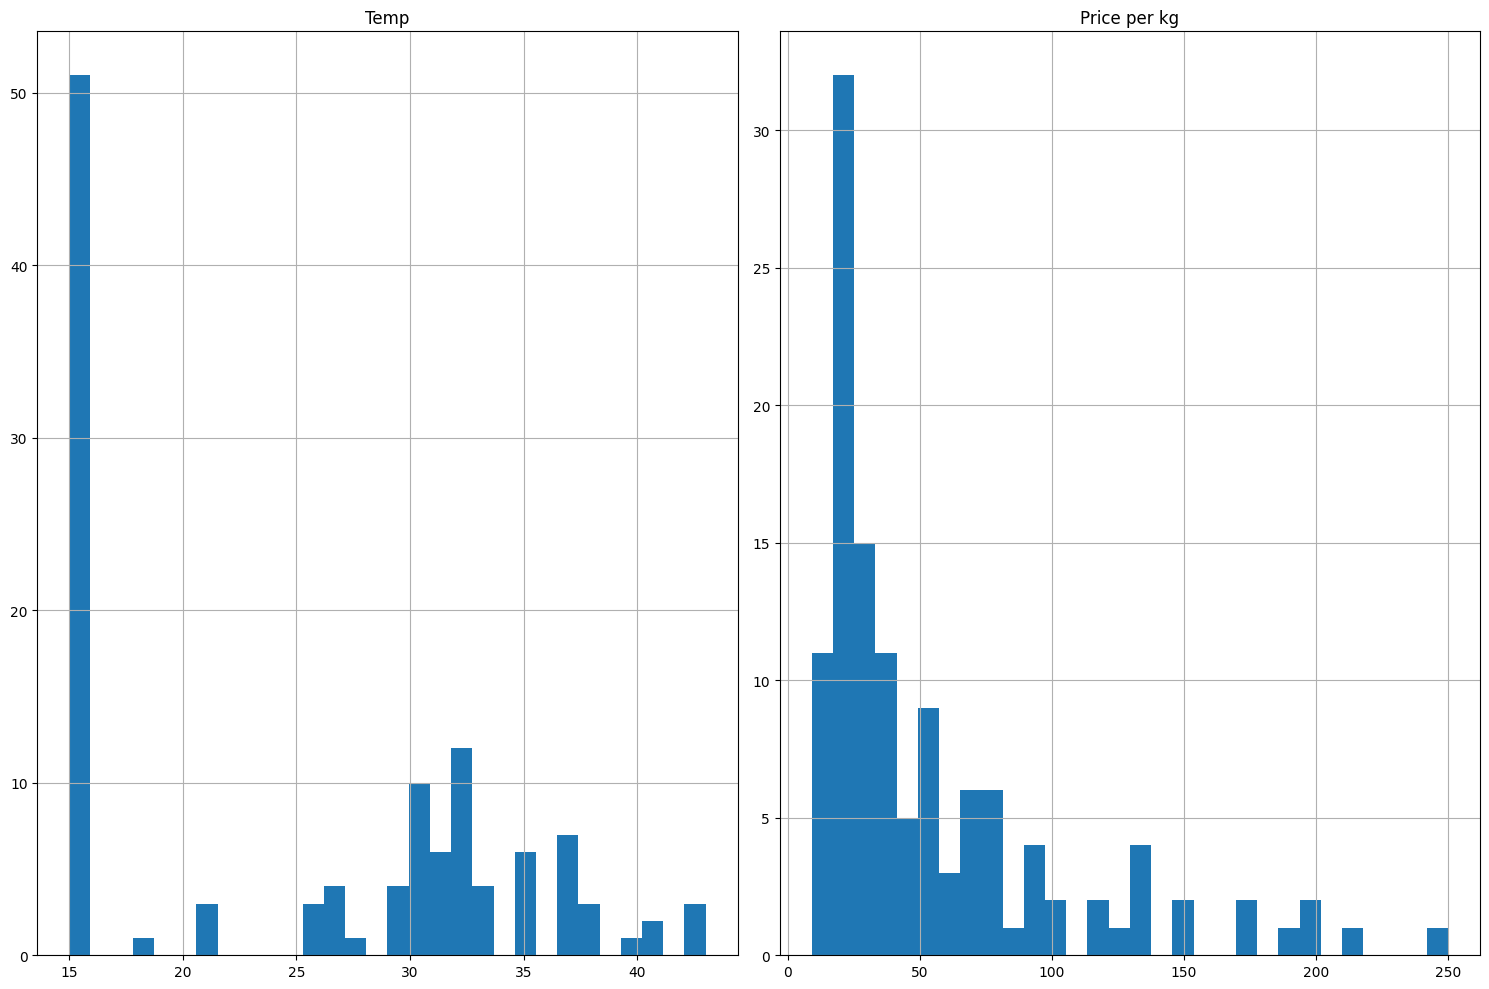

In [8]:
df_vegetable.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


### Distribution des données catégorielles

Index(['Vegetable', 'Season', 'Month', 'Deasaster Happen in last 3month',
       'Vegetable condition'],
      dtype='object')


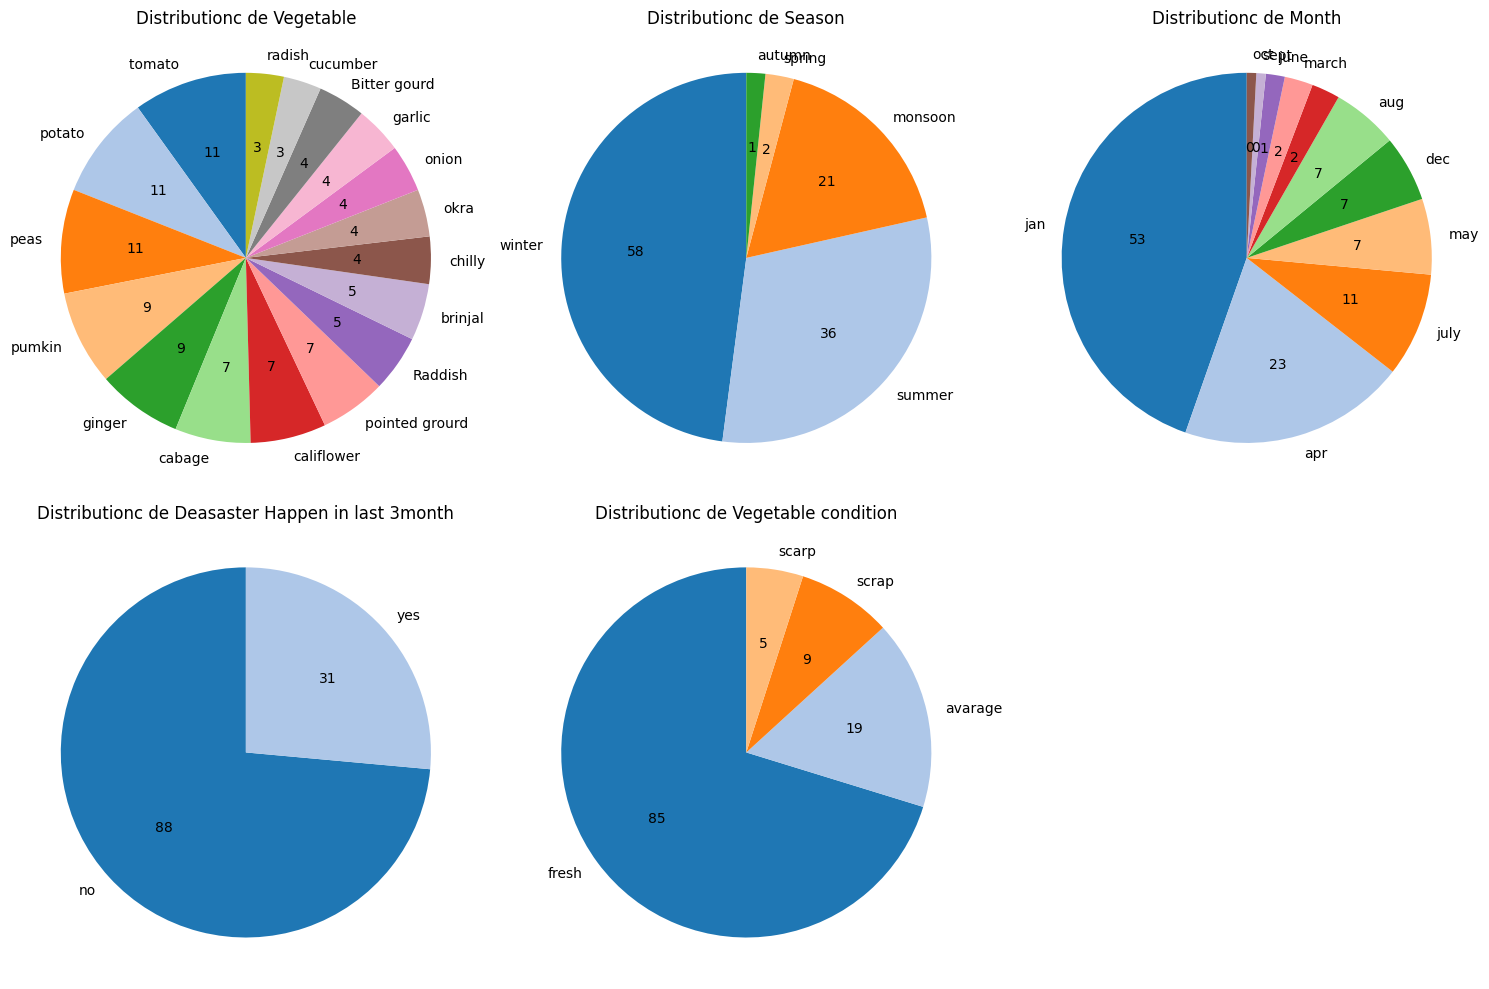

In [9]:
# Récupération variables ctaégorielles
categorical_columns = df_vegetable.select_dtypes(include=['object']).columns
print(categorical_columns)

# nombre de colonnes pour le subplots
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes

## Figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Aplatir l'array des axes pour un accès facile

for i, column in enumerate(categorical_columns):
    counts = df_vegetable[column].value_counts()
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct=lambda p: f'{int(p * sum(counts) / 100)}' if p > 0 else '',
        startangle=90,
        colors=plt.cm.tab20.colors
    )
    axes[i].set_title(f'Distributionc de {column}')
    axes[i].axis('equal')

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Matrice de corrélation

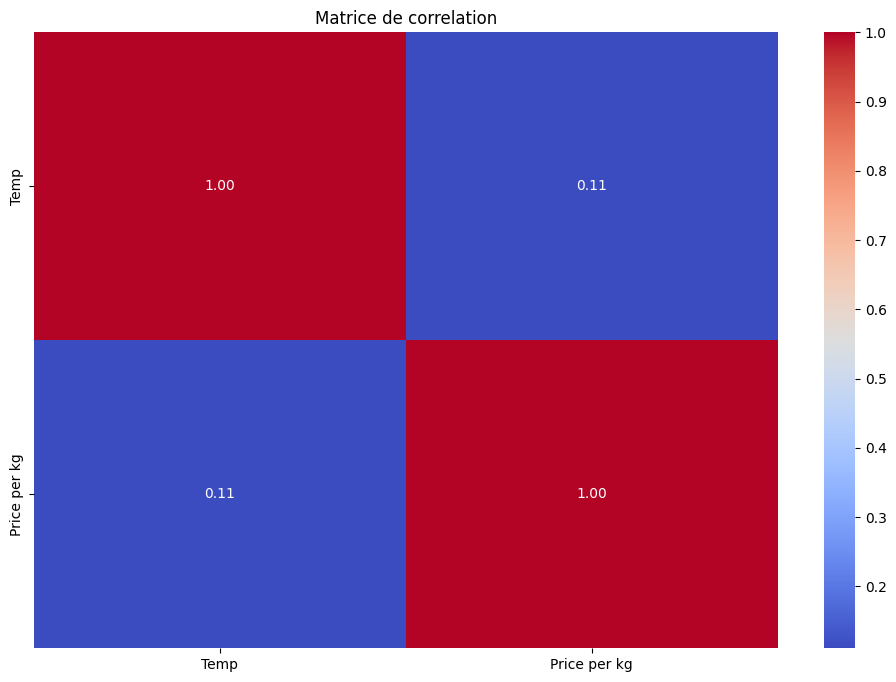

In [10]:
numeric_df = df_vegetable.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()


## H2O AutoML

### Conversion du dataframe pandas en dataframe H2O

In [ ]:
# Conversion du dataframe pandas en dataframe H2O (df specifique)
h2o_df = h2o.H2OFrame(df_vegetable)

##gere automatiquement l'encodage des données

#Echantillonage
trainforh2o, testforh2o = h2o_df.split_frame(ratios = [0.8])
##Définition de la variable cible
yforh2o = "Price per kg"

h2o_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Vegetable,Season,Month,Temp,Deasaster Happen in last 3month,Vegetable condition,Price per kg
potato,winter,jan,15,no,fresh,20
tomato,winter,jan,15,no,fresh,50
peas,winter,jan,15,no,fresh,70
pumkin,winter,jan,15,no,fresh,25
cucumber,winter,jan,15,no,fresh,20
pointed grourd,winter,jan,15,yes,fresh,130
Raddish,winter,jan,15,no,fresh,10
Bitter gourd,winter,jan,15,no,fresh,35
onion,winter,jan,15,no,fresh,35
tomato,winter,jan,15,no,fresh,45


### Instanciation et Entraînement de l'AutoML

In [ ]:
#Instanciation de l'automl
aml = H2OAutoML(max_runtime_secs = 60)

#Entrainement sur les données
aml.train(y = yforh2o, training_frame = trainforh2o, leaderboard_frame = testforh2o)



AutoML progress: |███
09:46:40.78: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 98.0.

████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20241024_94634_model_9


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    89                 89                          9743                   2            4            2.8764        3             6             4.02247

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 346.94383608873034
RMSE: 18.626428430827268
MAE: 12.68387744864639
RMSLE: 0.34357799442831655
Mean Residual Deviance: 346.94383608873034

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 725.2082869353468
RMSE: 26.929691549205437
MAE: 19.62513147504424
RMSLE: 0.5354098626420652
Mean Residual Deviance: 725.2082869353468

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0          nan           nan           nan           nan           nan
loglikelihood           nan       0          nan           nan           nan           nan           nan
mae                     19.6482   3.50258    15.1928       18.7774       21.8938       18.1326       24.2443
mean_residual_deviance  729.67    213.085    388.527       777.04        702.172       817.385       963.226
mse                     729.67    213.085    388.527       777.04        702.172       817.385       963.226
r2                      0.656416  0.202953   0.822063      0.702385      0.713147      0.741313      0.303171
residual_deviance       729.67    213.085    388.527       777.04        702.172       817.385       963.226
rmse                    26.7422   4.26116    19.7111       27.8754       26.4985       28.5899       31.0359
rmsle                   0.52618   0.0922866  0.479676      0.392235      0.574197      0.630401      0.554389

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-10-24 09:47:21  4.777 sec   0                  48.7892          35.7555         2380.38
    2024-10-24 09:47:21  4.782 sec   5                  44.4534          31.885          1976.11
    2024-10-24 09:47:21  4.786 sec   10                 40.626           28.7094         1650.47
    2024-10-24 09:47:21  4.790 sec   15                 35.9471          24.971          1292.2
    2024-10-24 09:47:21  4.795 sec   20                 33.3285          22.7007         1110.79
    2024-10-24 09:47:21  4.800 sec   25                 31.4243          21.1368         987.484
    2024-10-24 09:47:21  4.804 sec   30                 29.4251          19.7353         865.835
    2024-10-24 09:47:21  4.808 sec   35                 27.0866          18.0783         733.684
    2024-10-24 09:47:21  4.813 sec   40                 25.3612          17.006          643.19
    2024-10-24 09:47:21  4.817 sec   45                 24.2016          16.2232         585.719
    2024-10-24 09:47:21  4.822 sec   50                 23.0862          15.5269         532.972
    2024-10-24 09:47:21  4.827 sec   55                 21.9853          14.8403         483.352
    2024-10-24 09:47:21  4.831 sec   60                 21.4338          14.6692         459.408
    2024-10-24 09:47:21  4.835 sec   65                 21.1279          14.6368         446.39
    2024-10-24 09:47:21  4.840 sec   70                 19.9812          13.6375         399.248
    2024-10-24 09:47:21  4.845 sec   75        

 ### Classement des modèles

In [ ]:
print("Leaderboard des modèles AutoML")
print(aml.leaderboard)


Leaderboard des modèles AutoML
model_id                                                   rmse      mse      mae     rmsle    mean_residual_deviance
GBM_grid_1_AutoML_1_20241024_94634_model_9              28.388   805.877  17.7133  0.47607                    805.877
GBM_grid_1_AutoML_1_20241024_94634_model_16             28.505   812.537  17.1264  0.46021                    812.537
GBM_grid_1_AutoML_1_20241024_94634_model_10             28.6133  818.724  17.1722  0.458468                   818.724
StackedEnsemble_BestOfFamily_3_AutoML_1_20241024_94634  29.7018  882.199  18.1662  0.457511                   882.199
GBM_5_AutoML_1_20241024_94634                           29.8236  889.449  18.5114  0.454397                   889.449
StackedEnsemble_AllModels_2_AutoML_1_20241024_94634     29.8586  891.535  18.0133  0.454827                   891.535
StackedEnsemble_BestOfFamily_4_AutoML_1_20241024_94634  29.8944  893.675  18.4088  0.471535                   893.675
GBM_grid_1_AutoML_1_20241

### Résultats

In [ ]:
# Récupération du meilleur modèle
best_model = aml.leader

# Utilisation du meilleur modèle pour prédire les données de test
pred = best_model.predict(testforh2o)

# Évaluation des performances du modèle
perf = best_model.model_performance(testforh2o)

# Affichage des résultats des performances
print("Évaluation du modèle sur le jeu de test")
print(f"MSE: {perf.mse()}")
print(f"RMSE: {perf.rmse()}")

# Affichage des détails du meilleur modèle
print("Détails du meilleur modèle")
print(best_model)

# Vérification du type du meilleur modèle
model_type = best_model.algo
print(f"Type de modèle : {model_type}")




gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Évaluation du modèle sur le jeu de test
MSE: 805.8767918823899
RMSE: 28.38796913980269
Détails du meilleur modèle
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20241024_94634_model_9


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    89                 89                          9743                   2            4            2.8764        3             6             4.02247

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 346.94383608873034
RMSE: 18.626428430827268
MAE: 12.68387744864639
RMSLE: 0.34357799442831655
Mean Residual Deviance: 346.9

### Explications du modèle

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

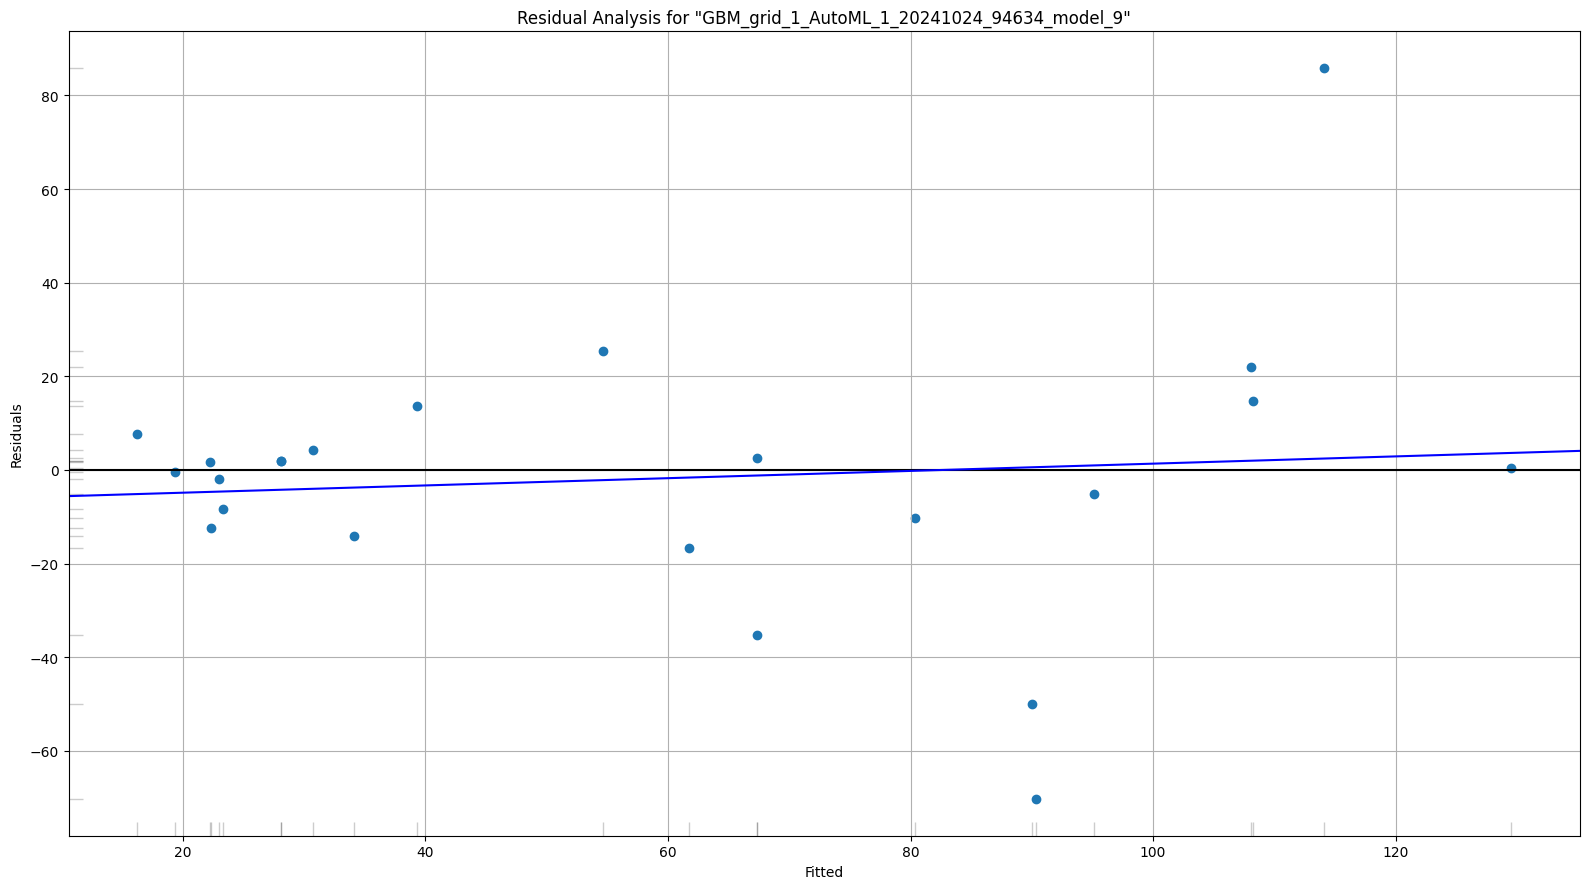

In [ ]:
# Analyse des Résidus (indiqué que pour la régression)
residual_explanation = h2o.explain(best_model, testforh2o, include_explanations="residual_analysis")



In [ ]:
#Fermeture du cluster de H2O
h2o.cluster().shutdown()

H2O session _sid_b755 closed.


## LazyPredict AutoML

### Prétraitement minimal

In [ ]:
cat_col = ["Vegetable", "Season", "Month", "Deasaster Happen in last 3month", "Vegetable condition"]

data_forlazypredict = pd.get_dummies(df_vegetable, columns = cat_col)

Xforlazypredict = data_forlazypredict.drop(columns=['Price per kg'])
yforlazypredict = data_forlazypredict['Price per kg']

Xforlazypredict = Xforlazypredict.astype(np.float32)

### Split Train/Test

In [ ]:
X_trainforlazypredict, X_testforlazypredict, y_trainforlazypredict, y_testforlazypredict = train_test_split(Xforlazypredict, yforlazypredict, train_size = 0.8, random_state = 42)

### Utilisation de LazyPredict

In [ ]:
reg = LazyRegressor(predictions=True,verbose=1,ignore_warnings=True, custom_metric=None)

### Fit le modèle

In [ ]:
models,predictions = reg.fit(X_trainforlazypredict, X_testforlazypredict, y_trainforlazypredict, y_testforlazypredict)

  2%|▏         | 1/42 [00:00<00:04,  8.60it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7944233855716794, 'Adjusted R-Squared': 1.308364921642481, 'RMSE': 25.18667595625701, 'Time taken': 0.11607789993286133}


 12%|█▏        | 5/42 [00:00<00:01, 24.37it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9248791106980564, 'Adjusted R-Squared': 1.1126813339529154, 'RMSE': 15.225247466013828, 'Time taken': 0.04486703872680664}
{'Model': 'BayesianRidge', 'R-Squared': 0.8681309223175049, 'Adjusted R-Squared': 1.1978036165237427, 'RMSE': 20.172302155842974, 'Time taken': 0.021330595016479492}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9541090788928952, 'Adjusted R-Squared': 1.0688363816606572, 'RMSE': 11.900011671329477, 'Time taken': 0.021522998809814453}
{'Model': 'DummyRegressor', 'R-Squared': -0.0004640645435889379, 'Adjusted R-Squared': 2.5006960968153833, 'RMSE': 55.56287979497742, 'Time taken': 0.019950151443481445}
{'Model': 'ElasticNet', 'R-Squared': 0.7663938403129578, 'Adjusted R-Squared': 1.3504092395305634, 'RMSE': 26.84887666216186, 'Time taken': 0.026470184326171875}


 26%|██▌       | 11/42 [00:00<00:01, 18.00it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8487849235534668, 'Adjusted R-Squared': 1.2268226146697998, 'RMSE': 21.60137994442319, 'Time taken': 0.1385056972503662}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.953744505875628, 'Adjusted R-Squared': 1.069383241186558, 'RMSE': 11.947187023637731, 'Time taken': 0.01426386833190918}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9564488618523699, 'Adjusted R-Squared': 1.0653267072214452, 'RMSE': 11.592677506847929, 'Time taken': 0.1437370777130127}
{'Model': 'GammaRegressor', 'R-Squared': 0.6051319092460267, 'Adjusted R-Squared': 1.59230213613096, 'RMSE': 34.9067985675793, 'Time taken': 0.022140026092529297}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.8691299888060647, 'Adjusted R-Squared': 1.1963050167909028, 'RMSE': 20.09574307992276, 'Time taken': 0.018994569778442383}


 31%|███       | 13/42 [00:00<00:02, 12.45it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9443819613755694, 'Adjusted R-Squared': 1.0834270579366458, 'RMSE': 13.100619549323985, 'Time taken': 0.18600702285766602}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.32139827507596974, 'Adjusted R-Squared': 2.0179025873860454, 'RMSE': 45.76057570150678, 'Time taken': 0.09840989112854004}
{'Model': 'HuberRegressor', 'R-Squared': 0.8381961888341993, 'Adjusted R-Squared': 1.242705716748701, 'RMSE': 22.344897837795667, 'Time taken': 0.07654809951782227}


 43%|████▎     | 18/42 [00:01<00:01, 14.81it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.40678130441049754, 'Adjusted R-Squared': 1.8898280433842536, 'RMSE': 42.784988021501185, 'Time taken': 0.027499914169311523}
{'Model': 'KernelRidge', 'R-Squared': -0.07470853803238064, 'Adjusted R-Squared': 2.612062807048571, 'RMSE': 57.58764907681144, 'Time taken': 0.029099464416503906}
{'Model': 'Lars', 'R-Squared': -1.3876916497311334e+17, 'Adjusted R-Squared': 2.0815374745967e+17, 'RMSE': 20693334465.900475, 'Time taken': 0.0483705997467041}
{'Model': 'LarsCV', 'R-Squared': 0.7695860862731934, 'Adjusted R-Squared': 1.34562087059021, 'RMSE': 26.66480191732627, 'Time taken': 0.09475016593933105}


 52%|█████▏    | 22/42 [00:01<00:01, 11.99it/s]

{'Model': 'Lasso', 'R-Squared': 0.8787552118301392, 'Adjusted R-Squared': 1.1818671822547913, 'RMSE': 19.342630826669406, 'Time taken': 0.026581525802612305}
{'Model': 'LassoCV', 'R-Squared': 0.8532406687736511, 'Adjusted R-Squared': 1.2201389968395233, 'RMSE': 21.28074860610503, 'Time taken': 0.2905709743499756}
{'Model': 'LassoLars', 'R-Squared': 0.87656170129776, 'Adjusted R-Squared': 1.18515744805336, 'RMSE': 19.51681371443772, 'Time taken': 0.031386375427246094}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8637377619743347, 'Adjusted R-Squared': 1.204393357038498, 'RMSE': 20.505565082726882, 'Time taken': 0.08586311340332031}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8528677225112915, 'Adjusted R-Squared': 1.2206984162330627, 'RMSE': 21.30776633626981, 'Time taken': 0.031161785125732422}
{'Model': 'LinearRegression', 'R-Squared': 0.8109239339828491, 'Adjusted R-Squared': 1.2836140990257263, 'RMSE': 24.154733002403415, 'Time taken': 0.019546031951904297}
{'Model': 'LinearSVR', 'R-Squared'

 67%|██████▋   | 28/42 [00:02<00:01,  9.28it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.023590683937072754, 'Adjusted R-Squared': 2.464613974094391, 'RMSE': 54.890846604507914, 'Time taken': 0.5746681690216064}
{'Model': 'NuSVR', 'R-Squared': 0.0023794651896171803, 'Adjusted R-Squared': 2.496430802215574, 'RMSE': 55.48386290184503, 'Time taken': 0.07989811897277832}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.593172013759613, 'Adjusted R-Squared': 1.6102419793605804, 'RMSE': 35.4314879310601, 'Time taken': 0.04718804359436035}


 71%|███████▏  | 30/42 [00:02<00:01, 10.48it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7529335618019104, 'Adjusted R-Squared': 1.3705996572971344, 'RMSE': 27.611554481254792, 'Time taken': 0.06443905830383301}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8658668800470828, 'Adjusted R-Squared': 1.2011996799293758, 'RMSE': 20.344733868097265, 'Time taken': 0.04792952537536621}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9244128690044175, 'Adjusted R-Squared': 1.1133806964933737, 'RMSE': 15.272422524458193, 'Time taken': 0.036438941955566406}
{'Model': 'QuantileRegressor', 'R-Squared': -0.14674903273107365, 'Adjusted R-Squared': 2.7201235490966105, 'RMSE': 59.486469049692296, 'Time taken': 0.042864322662353516}


 79%|███████▊  | 33/42 [00:02<00:00,  9.92it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.7076363563537598, 'Adjusted R-Squared': 1.4385454654693604, 'RMSE': 30.03624625087425, 'Time taken': 0.24202942848205566}


 88%|████████▊ | 37/42 [00:03<00:00,  9.73it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9119613957534168, 'Adjusted R-Squared': 1.1320579063698748, 'RMSE': 16.482404734924845, 'Time taken': 0.31159305572509766}
{'Model': 'Ridge', 'R-Squared': 0.8450967669487, 'Adjusted R-Squared': 1.23235484957695, 'RMSE': 21.86322673049289, 'Time taken': 0.02011585235595703}
{'Model': 'RidgeCV', 'R-Squared': 0.8712389962402398, 'Adjusted R-Squared': 1.1931415056396402, 'RMSE': 19.933161099521424, 'Time taken': 0.06973671913146973}
{'Model': 'SGDRegressor', 'R-Squared': 0.8741344627429531, 'Adjusted R-Squared': 1.1887983058855702, 'RMSE': 19.707766901723154, 'Time taken': 0.04992222785949707}
{'Model': 'SVR', 'R-Squared': -0.10618438994948765, 'Adjusted R-Squared': 2.6592765849242315, 'RMSE': 58.42487107731735, 'Time taken': 0.04569196701049805}


 95%|█████████▌| 40/42 [00:03<00:00, 12.54it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8109239339828491, 'Adjusted R-Squared': 1.2836140990257263, 'RMSE': 24.154733002403415, 'Time taken': 0.037278175354003906}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6815470806779228, 'Adjusted R-Squared': 1.4776793789831157, 'RMSE': 31.347767511718228, 'Time taken': 0.025328636169433594}


100%|██████████| 42/42 [00:05<00:00,  8.25it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9597822427749634, 'Adjusted R-Squared': 1.060326635837555, 'RMSE': 11.140197311918635, 'Time taken': 1.556056022644043}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 7
[LightGBM] [Info] Start training from score 55.083333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

### Résultats

In [ ]:
print(models)

                                 Adjusted R-Squared              R-Squared  \
Model                                                                        
Lars                          208153747459670016.00 -138769164973113344.00   
QuantileRegressor                              2.72                  -0.15   
SVR                                            2.66                  -0.11   
KernelRidge                                    2.61                  -0.07   
DummyRegressor                                 2.50                  -0.00   
NuSVR                                          2.50                   0.00   
MLPRegressor                                   2.46                   0.02   
LGBMRegressor                                  2.02                   0.32   
HistGradientBoostingRegressor                  2.02                   0.32   
KNeighborsRegressor                            1.89                   0.41   
LinearSVR                                      1.75             

## TPOT autoML

### Initialisation données (prétraitement) - Paramètres modèle

In [ ]:
# Categorical Variables
cat_col = ["Vegetable", "Season", "Month", "Deasaster Happen in last 3month", "Vegetable condition"]

# Values
XforTPOT = df_vegetable.drop("Price per kg", axis = 1)
yforTPOT = df_vegetable["Price per kg"]

# One-Hot Encoding
XforTPOT = pd.get_dummies(XforTPOT, columns = cat_col)

# Train-Test Split
X_trainforTPOT, X_testforTPOT, y_trainforTPOT, y_testforTPOT = train_test_split(XforTPOT, yforTPOT, test_size= 0.25)

# Cross-Validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

### Définition modèle

In [ ]:
# Model Definition
modelTPOT = TPOTRegressor(
    generations = 10,
    population_size = 20,
    cv = cv,
    scoring = "neg_mean_squared_error",
    verbosity = 2,
    n_jobs = -2,
    random_state = 1,
)

### Entraînement modèle

In [ ]:
# Fitting
modelTPOT.fit(X_trainforTPOT, y_trainforTPOT)

Optimization Progress:   0%|          | 0/220 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -654.8172552873506

Generation 2 - Current best internal CV score: -654.8172552873506

Generation 3 - Current best internal CV score: -654.8172552873506

Generation 4 - Current best internal CV score: -654.8172552873506

Generation 5 - Current best internal CV score: -574.9466521513821

Generation 6 - Current best internal CV score: -574.9466521513821

Generation 7 - Current best internal CV score: -574.9466521513821

Generation 8 - Current best internal CV score: -574.9466521513821

Generation 9 - Current best internal CV score: -537.7708478616972

Generation 10 - Current best internal CV score: -511.6678154352945

Best pipeline: KNeighborsRegressor(AdaBoostRegressor(MinMaxScaler(input_matrix), learning_rate=0.001, loss=exponential, n_estimators=100), n_neighbors=71, p=2, weights=distance)


TPOTRegressor(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
              generations=10, n_jobs=-2, population_size=20, random_state=1,
              scoring='neg_mean_squared_error', verbosity=2)

### Affichage du score

In [ ]:
# Print Score
accuracy_score = modelTPOT.score(X_testforTPOT, y_testforTPOT)
print(accuracy_score)

-1591.1442796503904


## Export du modèle

In [ ]:
# Export Model
modelTPOT.export(f"Vegetable_TPOT.py")